# Yoga Pose Scoring (Video)

## Imports and Constants

In [27]:
import numpy as np
from collections import deque
import json
import mediapipe as mp
from mediapipe.tasks.python import vision
from mediapipe.tasks import python
import os
import cv2
import pandas as pd
from cv2 import IMREAD_UNCHANGED
import matplotlib.pyplot as plt

## Map Landmark Mapping

In [28]:
# def compute_angle(a, b, c):
#     """
#     Compute angle ABC (in degrees) given 3 points.
#     a, b, c are numpy arrays of shape (2,) or (3,)
#     """
#     ba = a - b
#     bc = c - b

#     cosine_angle = np.dot(ba, bc) / (
#         np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6
#     )
#     angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
#     return np.degrees(angle)

def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle > 180.0:
        angle = 360-angle

    return angle


## Extract Pose Landmarks

In [ ]:
# Create a PoseLandmarker object.
base_options = mp.tasks.BaseOptions(
    model_asset_path='pose_landmarker_heavy.task'
)
options = mp.tasks.vision.PoseLandmarkerOptions(
    base_options=base_options,
    running_mode=vision.RunningMode.VIDEO,
    output_segmentation_masks=True)
video_landmarker = mp.tasks.vision.PoseLandmarker.create_from_options(options)

I0000 00:00:1770549554.388246 13253454 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1770549554.480253 13253456 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1770549554.495841 13253456 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


## Pose Normalization

In [30]:
def normalize_landmarks(landmarks):
    left_hip = landmarks[LANDMARKS["left_hip"]]
    right_hip = landmarks[LANDMARKS["right_hip"]]
    hip_center = (left_hip + right_hip) / 2

    left_shoulder = landmarks[LANDMARKS["left_shoulder"]]
    right_shoulder = landmarks[LANDMARKS["right_shoulder"]]
    shoulder_width = np.linalg.norm(left_shoulder - right_shoulder) + 1e-6

    normalized = (landmarks - hip_center) / shoulder_width
    return normalized


## Feature Extraction

In [31]:
def extract_joint_angles(lm):
    return {
        "left_knee": calculate_angle(
            lm[LANDMARKS["left_hip"]],
            lm[LANDMARKS["left_knee"]],
            lm[LANDMARKS["left_ankle"]],
        ),
        "right_knee": calculate_angle(
            lm[LANDMARKS["right_hip"]],
            lm[LANDMARKS["right_knee"]],
            lm[LANDMARKS["right_ankle"]],
        ),
        "left_hip": calculate_angle(
            lm[LANDMARKS["left_shoulder"]],
            lm[LANDMARKS["left_hip"]],
            lm[LANDMARKS["left_knee"]],
        ),
        "right_hip": calculate_angle(
            lm[LANDMARKS["right_shoulder"]],
            lm[LANDMARKS["right_hip"]],
            lm[LANDMARKS["right_knee"]],
        ),
        # "left_elbow": calculate_angle(
        #     lm[LANDMARKS["left_shoulder"]],
        #     lm[LANDMARKS["left_elbow"]],
        #     lm[LANDMARKS["left_wrist"]],
        # ),
        # "right_elbow": calculate_angle(
        #     lm[LANDMARKS["right_shoulder"]],
        #     lm[LANDMARKS["right_elbow"]],
        #     lm[LANDMARKS["right_wrist"]],
        # ),
    }


## Reference Pose Detection

In [32]:
LANDMARKS = {
    "left_shoulder": 11,
    "right_shoulder": 12,
    "left_elbow": 13,
    "right_elbow": 14,
    "left_wrist": 15,
    "right_wrist": 16,
    "left_hip": 23,
    "right_hip": 24,
    "left_knee": 25,
    "right_knee": 26,
    "left_ankle": 27,
    "right_ankle": 28
}

ANGLE_TOLERANCE = 15.0

# lm = json.load(open('yoga_landmarks/tree_2.json'))
# lm = pd.read_json('yoga_landmarks/tree_2.json')
# lm = np.array(lm)
# reference_angles = extract_joint_angles(lm) 
with open('reference/ground_truth_tree.json', 'r') as f:
    pose_library = json.load(f)

reference_angles = pose_library["Vrksasana"]


## MAE Based Pose Scoring

In [33]:
# def compute_weighted_mae(user_angles, ref_angles, weights):
#     total_error = 0.0

#     for joint, ref_angle in ref_angles.items():
#         if joint not in user_angles:
#             continue
#         error = abs(user_angles[joint] - ref_angle)
#         total_error += weights[joint] * error

#     return total_error


## Convert MAE to Score (0 - 100)

In [34]:
def get_shortest_angle_distance(a, b):
    """Calculates the shortest distance between two angles in degrees."""
    diff = (b - a + 180) % 360 - 180
    return abs(diff)

def mae_to_score(mae, tolerance=ANGLE_TOLERANCE):
    # sigma = tolerance
    # score = np.exp(-0.5 * (mae / sigma) ** 2)
    # return score * 100
    
    if mae <= tolerance:
        return 100.0
    cutoff = 45.0
    score = max(0.0, 1.0 - (mae - tolerance) / (cutoff - tolerance))
    # score = max(0.0, 1.0 - mae / tolerance)
    return score * 100

def compute_mae(user_angles, reference_pose):
    total_error = 0.0
    total_weight = 0.0

    for joint, ref_angle in reference_pose.items():
        if joint not in user_angles:
            continue
        error = get_shortest_angle_distance(user_angles[joint], ref_angle)
        total_error += error
        # total_error += abs(user_angles[joint] - ref_angle)
        total_weight += 1

    return total_error / (total_weight + 1e-6)

## Pose Scoring Pipeline

In [35]:
def load_image(image_path):
    image = cv2.imread(image_path, IMREAD_UNCHANGED)
    if image is None:
        raise ValueError("Image not found")
    return image

In [36]:
def score_pose_from_image(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert to MediaPipe Image
    mp_image = mp.Image(
        image_format=mp.ImageFormat.SRGB,
        data=rgb
    )

    # Run pose landmarker
    result = pose_landmarker.detect(mp_image)

    if not result.pose_landmarks:
        return None

    # Extract landmarks (first detected person)
    landmarks = result.pose_landmarks[0]

    # Convert to numpy array (x, y only)
    landmarks_np = np.array(
        [[lm.x, lm.y] for lm in landmarks]
    )

    # Normalize + extract features
    landmarks_np = normalize_landmarks(landmarks_np)
    angles = extract_joint_angles(landmarks_np)

    # Score
    # reference_pose = get_tree_pose_reference(angles)
    # mae = weighted_mae(angles, reference_pose, POSE_WEIGHTS)
    mae = compute_mae(angles, reference_angles)
    score = mae_to_score(mae)


    return {
        "score": round(score, 2),
        "mae": round(mae, 2),
        "angles": angles,
        "reference angles": reference_angles,
        "landmarks": landmarks,
    }


In [37]:
# image = load_image("/Users/weijie/Downloads/archive/Vrksasana/File12.png")
# image = load_image("images/tree_2.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [38]:
def show_result(image, show_plot):
    result = score_pose_from_image(image)
    landmark_list = result["landmarks"]

    if show_plot:
        annotated_image = image.copy()
        for idx, landmark in enumerate(landmark_list):
            x, y = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
            cv2.circle(annotated_image, (x, y), 5, (0, 255, 0), -1)

            # Draw connections
            connections = mp.tasks.vision.PoseLandmarksConnections.POSE_LANDMARKS
            for connection in connections:
                start_idx = connection.start
                end_idx = connection.end
                start_point = (int(landmark_list[start_idx].x * image.shape[1]),
                                int(landmark_list[start_idx].y * image.shape[0]))
                end_point = (int(landmark_list[end_idx].x * image.shape[1]),
                                int(landmark_list[end_idx].y * image.shape[0]))
                cv2.line(annotated_image, start_point, end_point, (255, 0, 0), 2)
            
        plt.figure(figsize=(10, 10))
        plt.imshow(annotated_image)
        plt.axis('off')
        plt.show()
    return result

In [39]:
# image = load_image("/Users/weijie/Downloads/archive/Vrksasana/File20.png")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# 
# result = show_result(image, show_plot=True) # show plot = False to disable plot
# 
# for k, v in result.items():
#     if k == 'angles' or k == 'reference angles':
#         print(f"{k}:")
#         for angle_k, angle_v in v.items():
#             print(f"\t{angle_k}: {angle_v}")
#     else:
#         print(f"{k}: {v}")

# Batch Processing

In [40]:
def batch_process_video(input_path):
    cap = cv2.VideoCapture(input_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    all_frame_landmarks = [] 
    
    # --- PHASE 1: Extraction Loop ---
    print("Starting Landmark Extraction...")
    frame_index = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        timestamp_ms = int((frame_index / fps) * 1000)
        
        detection_result = video_landmarker.detect_for_video(mp_image, timestamp_ms)
        
        if detection_result.pose_landmarks:
            all_frame_landmarks.append(detection_result.pose_landmarks[0])
        else:
            all_frame_landmarks.append(None)
            
        frame_index += 1

    cap.release()
    print(f"Extraction Complete. Collected landmarks for {len(all_frame_landmarks)} frames.")

    # --- PHASE 2: Batch Scoring Loop ---
    print("Starting Batch Scoring...")
    scores_over_time = []
    
    for i, landmarks in enumerate(all_frame_landmarks):
        if landmarks is None:
            scores_over_time.append(0.0) # Penalty for no detection
            continue
            
        landmarks_np = np.array([[lm.x, lm.y] for lm in landmarks])

        norm_landmarks = normalize_landmarks(landmarks_np)
        
        angles = extract_joint_angles(norm_landmarks)

        mae = compute_mae(angles, reference_angles)
        score = mae_to_score(mae)

        # print(f"Frame {i}:")
        # print(f"  User Angles: {angles}")
        # print(f"  Ref Angles: {reference_angles}")
        # print(f"  MAE: {mae}")
        # print(f"  Score: {score}")
        
        scores_over_time.append(score)

    return all_frame_landmarks, scores_over_time

In [41]:
def visualize_batch_results(input_path, output_path, all_landmarks, all_scores):
    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Initialize VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print("Generating Visualized Video...")
    frame_index = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Get data for this frame (if available)
        if frame_index < len(all_landmarks):
            landmarks = all_landmarks[frame_index]
            score = all_scores[frame_index]
            
            # --- DRAWING LOGIC STARTS HERE ---
            if landmarks:
                # 1. Draw Landmarks and Connections
                # (Reusing the logic from your show_result function)
                for idx, landmark in enumerate(landmarks):
                    x, y = int(landmark.x * width), int(landmark.y * height)
                    cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)

                connections = mp.tasks.vision.PoseLandmarksConnections.POSE_LANDMARKS
                for connection in connections:
                    start_idx = connection.start
                    end_idx = connection.end
                    
                    # Ensure indices are valid
                    if start_idx < len(landmarks) and end_idx < len(landmarks):
                        start_point = (int(landmarks[start_idx].x * width), int(landmarks[start_idx].y * height))
                        end_point = (int(landmarks[end_idx].x * width), int(landmarks[end_idx].y * height))
                        cv2.line(frame, start_point, end_point, (255, 0, 0), 2)

                # 2. Draw Score Text
                cv2.putText(frame, f"Score: {int(score)}", (50, 100), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            # --- DRAWING LOGIC ENDS HERE ---

        out.write(frame)
        frame_index += 1

    cap.release()
    out.release()
    print(f"Video saved to {output_path}")

In [42]:
import csv

def save_scores_to_csv(video_path, scores, csv_path):
    # 1. Get FPS to calculate accurate timestamps
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()

    if fps == 0:
        print("Error: Could not read FPS from video. Using default 30 FPS.")
        fps = 30.0

    print(f"Writing scores to {csv_path}...")

    # 2. Write to CSV
    with open(csv_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        
        # Header
        writer.writerow(['Frame Number', 'Timestamp (ms)', 'Score'])
        
        # Rows
        for frame_idx, score in enumerate(scores):
            # Calculate timestamp: (frame / fps) * 1000 to get milliseconds
            timestamp_ms = int((frame_idx / fps) * 1000)
            
            # Write row
            writer.writerow([frame_idx, timestamp_ms, f"{score:.2f}"])

    print(f"Successfully saved {len(scores)} rows to {csv_path}")


Starting Landmark Extraction...
Extraction Complete. Collected landmarks for 162 frames.
Starting Batch Scoring...
Generating Visualized Video...
Video saved to yoga_scored.mp4
Writing scores to yoga_scores.csv...
Successfully saved 162 rows to yoga_scores.csv


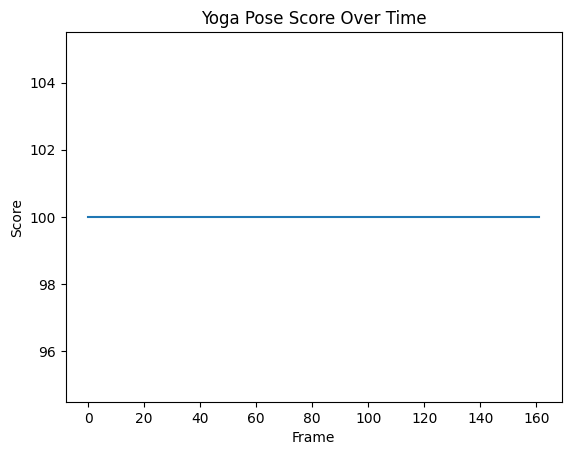

In [43]:
# path = "/Users/weijie/Documents/cs/fyp/yoga_videos/tree_pose_trimmed"
# video_path = path + ".mp4"
# frame_scores = batch_process_video(video_path)
# 
path = "/Users/weijie/Documents/cs/fyp/yoga_videos/"
input_video = path + "tree_pose_trimmed.mp4"
output_video = "yoga_scored.mp4"
csv_output_path = "yoga_scores.csv"

landmarks, scores = batch_process_video(input_video)

visualize_batch_results(input_video, output_video, landmarks, scores)

save_scores_to_csv(input_video, scores, csv_output_path)

# Plot the score progression
plt.plot(scores)
plt.title("Yoga Pose Score Over Time")
plt.xlabel("Frame")
plt.ylabel("Score")
plt.show()

# print("Displaying score of each frame")
# for score in scores:
#     print(score)


## In Camera Loop

In [44]:
# class StabilityTracker:
#     def __init__(self, window_size=30):
#         self.window_size = window_size
#         self.angle_history = deque(maxlen=window_size)

#     def update(self, angles):
#         self.angle_history.append(list(angles.values()))

#     def stability_score(self):
#         if len(self.angle_history) < 5:
#             return 1.0  # not enough data to penalize

#         variance = np.var(self.angle_history)
#         stability = np.exp(-variance)
#         return stability


In [45]:
# def score_pose(landmarks, stability_tracker=None):
#     # Normalize
#     landmarks = normalize_landmarks(landmarks)
# 
#     # Extract angles
#     user_angles = extract_joint_angles(landmarks)
# 
#     # MAE scoring
#     mae = compute_weighted_mae(
#         user_angles,
#         TREE_POSE_REFERENCE,
#         TREE_POSE_WEIGHTS
#     )
# 
#     base_score = mae_to_score(mae)
# 
#     # Stability bonus
#     if stability_tracker:
#         stability_tracker.update(user_angles)
#         stability = stability_tracker.stability_score()
#         final_score = base_score * stability
#     else:
#         final_score = base_score
# 
#     return {
#         "score": round(final_score, 2),
#         "mae": round(mae, 2),
#         "angles": user_angles
#     }
# 

In [46]:
# stability_tracker = StabilityTracker(window_size=45)
# 
# # landmarks should be a (33, 2) or (33, 3) numpy array from MediaPipe
# # Example:
# # landmarks = np.array([[x0,y0], [x1,y1], ...])
# 
# result = score_pose(landmarks, stability_tracker)
# 
# print("Score:", result["score"])
# print("MAE:", result["mae"])
# 